# Corsound wav into spectrogram

### Importing Packages

Importing the NumPy, Pandas and Matplotlib, PyTorch Scikit-Image etc. packages.

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm
import torch
from torchvision import datasets
from skimage.transform import resize
from skimage.io import imread, imsave
from scipy.io import wavfile


## This line makes matplotlib plot the figures inside the notebook
%matplotlib inline

## Set some default values of the the matplotlib plots
plt.rcParams['figure.figsize'] = (8.0, 8.0)  # Set default plot's sizes
plt.rcParams['axes.grid'] = True  # Show grid by default in figures

## Load Dataset

Loading wav files dataset and show some signals.

In [29]:
from os.path import split
import glob
path = '../test_txt/txt/test_txt/wav'
path_img = list(glob.glob(path+'/*/*/*.wav'))

labels = list(map(lambda x:split(split(x)[0])[-2], path_img))
labels = [label.split('/')[-1] for label in labels]
file_path = pd.Series(path_img, name='File_Path').astype(str)

labels = pd.Series(labels, name='Labels')
data = pd.concat([file_path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()


,File_Path,Labels
0,../test_txt/txt/test_txt/wav/id04119/k-TiNq0br...,id04119
1,../test_txt/txt/test_txt/wav/id08149/O_gtwphGl...,id08149
2,../test_txt/txt/test_txt/wav/id08149/O_gtwphGl...,id08149
3,../test_txt/txt/test_txt/wav/id08149/O_gtwphGl...,id08149
4,../test_txt/txt/test_txt/wav/id08149/ozGl4eZyZ...,id08149


length = 4.56s
number of channels = 2


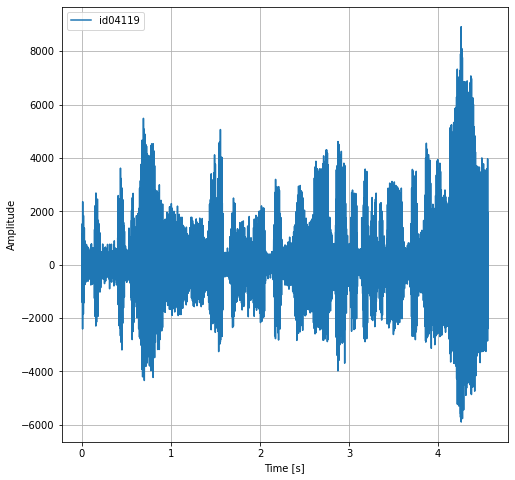

In [37]:
samplerate, signal = wavfile.read(data.File_Path[0])
length = signal.shape[0] / samplerate

print(f"length = {length}s")
print(f"number of channels = {data.shape[1]}")

time = np.linspace(0., length, signal.shape[0])
plt.plot(time, signal, label=data.Labels[0])
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()